# Sleep Apena

一如往常先 load Module and Function，以及 read image

In [1]:
import os                            # 與當按路徑建置、開啟相關的模組
import numpy as np                   # 與矩陣計算相關的模組
import pandas as pd                  # 用來整理資料表格或做前處理始用的模組
import matplotlib.pyplot as plt      # 用來做圖使用的模組
import cv2                           # 做影像前處理所需要的模組--opencv，此處簡稱 cv2
from tqdm import tqdm                # 進度視覺化函數

# 資料集載入、再觀察與處理

In [2]:
#20191205
#train_csv = pd.read_csv("blindness_data/medical_train.csv", index_col=False)
#test_csv = pd.read_csv("blindness_data/medical_test.csv", index_col=False)
#os.chdir('/media/why168168/0000678400004823/Sleep_Apnea/Benson/Deep_Learning')
train_csv = pd.read_csv("sleep_data/train.csv", index_col=False)
test_csv = pd.read_csv("sleep_data/test.csv", index_col=False)

In [3]:
#train_path = "./blindness_data/medical_train_img"  
train_path = "./sleep_data/Mel_train"  # 指定訓練集的讀檔路徑
train_data=[]                                                      # 先宣告一個空的 list 承接檔案
for eachfile in train_csv["Number"]:                              # 用 for 迴圈將檔案名稱一個個唱名
    image = cv2.imread(os.path.join(train_path, eachfile+".png"))  # 被唱到名的檔案就會和訓練集路徑用 os.path.join 結合
                                                                   # 用 cv2.imread 將檔案開啟
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                 # 由於 cv2 開檔讀進來的是 BGR 所以我們將其轉成 RGB
    train_data.append(image)                                       # 將開啟的檔案放到 train_data 中

In [4]:
test_path = "./sleep_data/Mel_test"
test_data=[]
for eachfile in test_csv["Number"]:
    image = cv2.imread(os.path.join(test_path, eachfile+".png"))    
    #print(eachfile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_data.append(image)

### 看它第三眼 (Observe 3)

In [5]:
#diabetes_type = {0: "No DR", 1:"Mild", 2:"Moderate", 3:"Severe", 4:"Proliferative DR"}
sleep_type = {0:"Normal", 1:"Sick"}

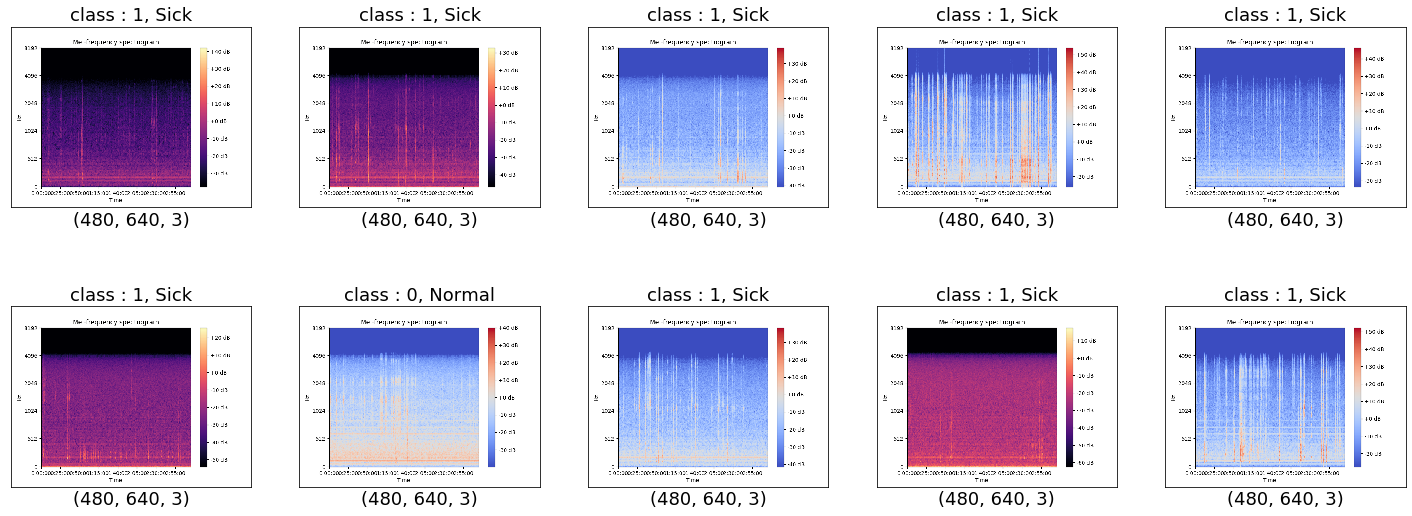

In [6]:
#20191114
plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
for i in range(10):
    ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置
    #plt.title("class : "+str(train_csv["diagnosis"][i] )+", "+str(diabetes_type[train_csv["diagnosis"][i]]), 
    plt.title("class : "+str(train_csv["Label"][i] )+", "+str(sleep_type[train_csv["Label"][i]]), 
               fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
    plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
    plt.yticks([])
    ax.set_xlabel(test_data[i].shape,fontsize=18) 
    ax.imshow(train_data[i])                                       # 將指定的影像放入呼叫的畫圖位置

In [7]:
#20191114
#plt.figure(figsize=(25,30))
#for i in range(30):
#    ax = plt.subplot(6, 5, i+1)
#    plt.xticks([]) 
#    plt.yticks([])
#    ax.imshow(test_data[i])

#### $\textbf{你發現了嗎??}$
#### $\textbf{訓練集和測試集行狀分布不一樣捏~}$
![Imgur](https://i.imgur.com/ML2NP5i.jpg?1)

### Preprocessing 2. Reflection
![Imgur](https://i.imgur.com/XmvGn33.jpg?1)

(a) 先做 cropping

image = train_data[1].copy()

gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray_img, 10, 1, cv2.THRESH_BINARY)

cond = np.argwhere(thresh == 1)
x_min = cond[:,0].min()
x_max = cond[:,0].max()
y_min = cond[:,1].min()
y_max = cond[:,1].max()
cut_img = image[x_min:x_max, y_min:y_max]

print("the shape of the original image: %s"% {image.shape})
print("the shape of the cropping image: %s"% {cut_img.shape})

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 7))
ax0.imshow(image)
ax0.set_title("Original Image")
ax1.imshow(cut_img)
ax1.set_title("Cropping")
plt.show()

(b) 將長邊當做直徑，短邊用靜射的方式補值，直至兩邊等長

h, w = cut_img.shape[0], cut_img.shape[1]    # 尋找影像長寬
delta = (w-h)//2                             # 找出長度差值

if delta>=0:
    if (w-h)%2!=0:
        refl_img = np.vstack([cut_img[0:delta][::-1], cut_img, cut_img[-delta-1:][::-1]])  # 垂直方向補值
    else:
        refl_img = np.vstack([cut_img[0:delta][::-1], cut_img, cut_img[-delta:][::-1]])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 7))
ax0.imshow( np.vstack([cut_img[0:delta][::-1], cut_img]))
ax0.set_xticks([])
ax0.set_yticks([])
ax1.imshow(refl_img)
ax1.set_xticks([])
ax1.set_yticks([])
plt.show()

(c) 以邊為直徑做一相切圓，進行裁切

diameter = refl_img.shape[0]        # 以邊作為直徑
radius = int(diameter/2)-1          # 然後裁減作為半徑

circle_mask = np.zeros((diameter, diameter), np.uint8)                           # 宣告一塊和影像大小一樣的空間
circle_mask = cv2.circle(circle_mask, (radius, radius), radius, 1, thickness=-1) # 在空間中作一個相切圓

cir_img = cv2.bitwise_and(refl_img, refl_img, mask=circle_mask)     # 用相切圓的形狀作影像裁減
cir_img = cv2.resize(cir_img,(512,512))                             # 裁減完後作一個一致性的 resize

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 10))
ax0.imshow(refl_img)
ax0.set_xticks([])
ax0.set_yticks([])
ax1.imshow(circle_mask, cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(cir_img)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

#### $\textbf{其實資料集影像不乾淨}$
![Imgur](https://i.imgur.com/jv6r0V7.jpg?1)

### Preprocessing 3. Cropping

crop_img = cir_img[256-200:256+200, 256-200:256+200]   
# 將 (512,512) 的影像只取以中心點 (400,400) 的正方形，減少不必要的邊特徵

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(cir_img)
ax0.set_title("Circle Image with shape: %s"% {cir_img.shape})
ax1.imshow(crop_img)
ax1.set_title("Cropping Image with shape: %s"% {crop_img.shape})
plt.show()

### Preprocessing 4. Image Processing

![Imgur](https://i.imgur.com/iOTSElj.jpg?1)![Imgur](https://i.imgur.com/gqdnfoH.jpg?1)

#### Preprocessing 4-1. Histogram

yuv = cv2.cvtColor(cir_img, cv2.COLOR_RGB2YUV)    # 將 RGB 轉成 YUV 格式，其中 Y 代表亮度
channels = cv2.split(yuv)                         # 將影像拆開
channels[0] = cv2.equalizeHist(channels[0])       # 針對 YUV 中的 Y 作 Histogram
yuv = cv2.merge(channels, yuv)                    # 將影像合起來
his_img = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)    # 再從 YUV 格式轉回 RGB

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(cir_img)
ax0.set_title("Original Image", fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])
ax1.imshow(his_img)
ax1.set_title("Histogram", fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])
plt.show()

#### Preprocessing 4-2. CLAHE ( Adaptive Histogram )

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cla_img = np.zeros_like(cir_img)
cla_img[:,:,0] = clahe.apply(cir_img[:,:,0])
cla_img[:,:,1] = clahe.apply(cir_img[:,:,1])
cla_img[:,:,2] = clahe.apply(cir_img[:,:,2])

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 10))
ax0.imshow(cir_img)
ax0.set_title("Original Image", fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(his_img)
ax1.set_title("Histogram", fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cla_img)
ax2.set_title("CLAHE", fontsize=20)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

#### Preprocessing 4-3. Gaussian

gau_img = cv2.addWeighted (cir_img, 4, cv2.GaussianBlur(cir_img , (0,0) , 30) ,-4 ,128)  
# 將影像過 Gaussian Filter 作去噪、模糊細節、邊緣偵測，再疊回原圖

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(cir_img)
ax0.set_title("Original Image", fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])
ax1.imshow(gau_img)
ax1.set_title("Gaussian", fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])
plt.show()

幫大家整理好了一個函數寫法，load 進來就可以用了

In [8]:
from utils.image_preprocessing import my_preprocessing
# my_preprocessing(
#                  dataset,     # 放入開完檔案的影像進此函述做前處理 
#                  outsize,     # output 時的 image size
#                  crop,        # 要不要做 crop
#                  pre_type     # 希望做什麼樣的特徵強化，共有["ori", "his", "cla", "gau"]四種可以填入
#                  )

In [9]:
pre_train = my_preprocessing(dataset = train_data, outsize=456, crop=False, pre_type="his")
pre_test  = my_preprocessing(dataset = test_data, outsize=456, crop=False, pre_type="his")
# outsize 設定 456 是為了放入底下模型所指定的 size
#20191205
print(train_data[0].shape)
print(pre_train[0].shape)
del train_data
del test_data

  9%|▊         | 10/115 [00:00<00:01, 99.99it/s]

refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (63

 29%|██▊       | 33/115 [00:00<00:00, 103.75it/s]

refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (63

 49%|████▊     | 56/115 [00:00<00:00, 106.27it/s]

refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (63

 69%|██████▊   | 79/115 [00:00<00:00, 107.09it/s]

refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (63

 88%|████████▊ | 101/115 [00:00<00:00, 107.39it/s]

refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (63

 48%|████▊     | 11/23 [00:00<00:00, 108.17it/s]

refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (63

100%|██████████| 23/23 [00:00<00:00, 111.36it/s]

refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
refl_img.shape: (639, 639, 3) mask=  (639, 639)
(480, 640, 3)
(456, 456, 3)


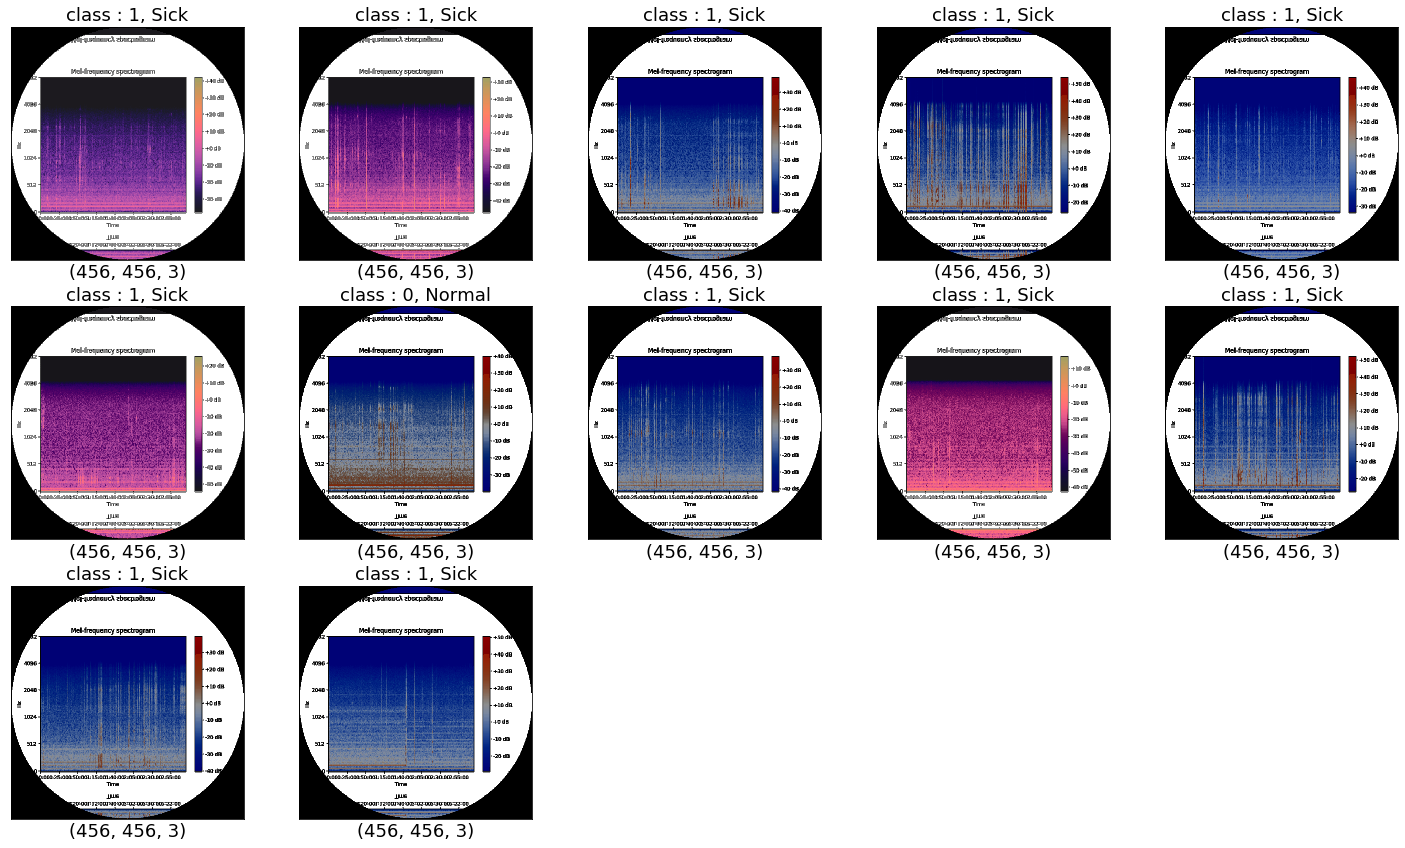

In [10]:
#20191114
plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
for i in range(12):
    ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置
    #plt.title("class : "+str(train_csv["diagnosis"][i] )+", "+str(diabetes_type[train_csv["diagnosis"][i]]), 
    plt.title("class : "+str(train_csv["Label"][i] )+", "+str(sleep_type[train_csv["Label"][i]]), 
               fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
    plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
    plt.yticks([])
    ax.set_xlabel(pre_train[i].shape, fontsize=18)
    ax.imshow(pre_train[i])                                       # 將指定的影像放入呼叫的畫圖位置

### Testing Dataset 中的意外--反光 (Observe 4)

![Imgur](https://i.imgur.com/tPeEjRn.jpg?1)

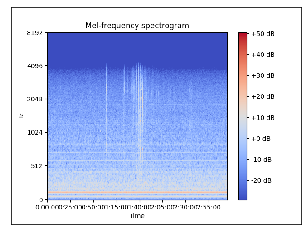

In [11]:
#plt.imshow(cv2.imread("./blindness_data/medical_illu_test_img/0cad3584e761.png")[:,:,::-1])
plt.imshow(cv2.imread("./sleep_data/Mel_test/00001037-100779.png")[:,:,::-1])
plt.xticks([])
plt.yticks([])
plt.show()

### Preprocessing 5. Image Inpainting

![Imgur](https://i.imgur.com/XxkPS2g.jpg?1)

Nvidia 強大的修圖工具 Image Inpainting<br>
https://www.nvidia.com/research/inpainting/

$\color{red}{\textbf{注意}}$<br>
$\color{red}{如果醫療影像涉及資料保密協定問題，請勿隨意上傳至此網站，以免觸法。}$

### Train_Test_Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_valid, Y_train, Y_valid = train_test_split( pre_train, 
                                                       #train_csv['diagnosis'].values,
                                                       train_csv['Label'].values,
                                                       test_size=0.1, 
                                                       random_state=10,
                                                       #stratify= train_csv['diagnosis'].values)
                                                       stratify= train_csv['Label'].values)

# 如何改善預測成效?
## 1. 資料方面: 增加資料量
## 2. 模型方面: 調參、改模型結構
## 3. 訓練方面: Optimizer, loss function, transfer learning

### 朝進化方向邁大步，讓我們來試試第一 + 第二種方法!

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Input, Dense, GlobalAveragePooling2D)
from keras.optimizers import SGD, Adam
#from efficientnet import EfficientNetB5, preprocess_input
#from efficientnet.keras import EfficientNetB5, preprocess_input
from keras_efficientnets import EfficientNetB5, preprocess_input


Using TensorFlow backend.


In [15]:
X_train = np.array([preprocess_input(image) for image in X_train])
X_valid = np.array([preprocess_input(image) for image in X_valid])
test_pred  = np.array([preprocess_input(image) for image in pre_test])

### Imbalance Data

[Notice] 底下兩者做其一即可，兩者多做很可能使得模型會壞掉，底下兩者做法相近，但效果不同，各有優點

(1) 計算原示資料類別比例之反比，就是說對應到的 label 資料量少的做模型更新時，權重比重較大，反之，資料量多的權重較小

In [16]:
from sklearn.utils import class_weight
classweight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
#classweights = {0: classweight[0], 1: classweight[1], 2: classweight[2], 3: classweight[3], 4: classweight[4]}
classweights = { 0: classweight[0], 1: classweight[1] }

(2) 對類別取一個比例，依照比例去增加其對應的資料之資料量，一般我們直接以複製資料做為增加的方式 (此例中我們選此法)<br>
![Imgur](https://i.imgur.com/LbxlfS3.jpg?1)

In [17]:
X_train_prod = X_train.copy()
Y_train_prod = Y_train.copy()

# 不同 label 補不同倍數的值
#???
task = {1:5, 2:2, 3:8, 4:7}
for i in range(1,5):
    tmp_x = X_train[Y_train==task[i]].copy()
    tmp_y = Y_train[Y_train==task[i]].copy()
    for j in range(task[i]):
        X_train_prod = np.concatenate([X_train_prod, tmp_x])
        Y_train_prod = np.concatenate([Y_train_prod, tmp_y])

### Data Augmentation  資料增強

In [18]:
datagen = ImageDataGenerator(
                                width_shift_range = 0.0,     # 水平平移
                                height_shift_range = 0.0,    # 垂直平移
                                rotation_range = 0,        # 0-180 任一角度旋轉
                                horizontal_flip = True,      # 任意水平翻轉
                                vertical_flip = True,        # 任意垂直翻轉
                                fill_mode = "constant",      # 在旋轉或平移時，有空隙發生，則空隙補常數
                                cval = 0                     # 設定常數值為 0
                             )

### Model 2. EfficientNet 超強神器

![Imgur](https://i.imgur.com/i8DZ1sR.jpg?1)

In [19]:
base_model = EfficientNetB5(weights='imagenet',include_top=False)

pool = GlobalAveragePooling2D()(base_model.output) 

output = Dense(5, activation='softmax')(pool)

model = Model(inputs = base_model.input, outputs = output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
#from keras.utils import plot_model
#plot_model(base_model, to_file='./outputs/EfficientNetB5_model.png')    # 畫畫模型圖

In [21]:
base_model.trainable = False

In [22]:
learning_rate = 1e-4
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

### 開始訓練

In [23]:
batch_sizes = 4
#num_epoch = 10
num_epoch = 2
step_size_train = len(X_train_prod)//batch_sizes
model_history = model.fit_generator(
                                    datagen.flow(X_train_prod, np.eye(5)[Y_train_prod], batch_size=batch_sizes),
                                    steps_per_epoch = step_size_train,
                                    validation_data = (X_valid, np.eye(5)[Y_valid]),
                                    epochs=num_epoch, verbose=1,
#                                     class_weight = classweights
                                    )

Epoch 1/2
25/25 [==============================] - 134s 5s/step - loss: 0.8019 - accuracy: 0.7980 - val_loss: 1.2180 - val_accuracy: 0.8333
Epoch 2/2
25/25 [==============================] - 120s 5s/step - loss: 0.3288 - accuracy: 0.9091 - val_loss: 1.0830 - val_accuracy: 0.7500


### 繪出訓練結果

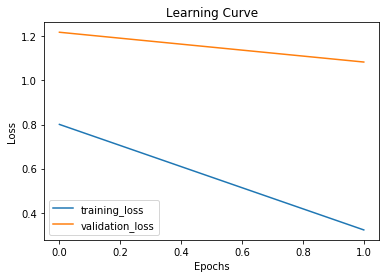

In [24]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [25]:
#model.save("./SavedModel/my_EfficientNet_model.h5")
model.save("./saved_models/sleep_apnea_2_v1.h5")

# 用驗證集驗證與評估成效

In [26]:
# 看看驗證集的效果即進行分析
valid_pred = model.predict(X_valid)     
# 因為 model.predict 的輸出為每一筆資料對應到 5個類別的機率值，因此會取最大機率值對應到的 index 當作其預測類別
valid_pred = valid_pred.argmax(-1)       

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

In [28]:
print(accuracy_score(Y_valid, valid_pred))                          # 觀看準確率
print(confusion_matrix(Y_valid, valid_pred))                        # 可以看出實際和預測的分布
print(cohen_kappa_score(Y_valid, valid_pred, weights='quadratic'))  # 衡量不平衡且類別關係為強弱對應關係的一種衡量方式

0.75
[[0 1]
 [2 9]]
-0.125


### Scoring Performence

In [29]:
# model = load_model("./SavedModel/my_first_model.h5")    # 可以直接從這邊把自己訓練完的模型和權重 load 進來，就不用每次都要重新 training

In [30]:
test_pred = model.predict(pre_test).argmax(-1)

覺得驗證集結果還不錯，就將 testing data 丟進去 model 做預測，存起來後看看上傳結果吧！

In [31]:
#test_csv.loc[:,"diagnosis"] = test_pred
#test_csv.to_csv("./outputs/my_EfficientNet_TestPrediction.csv", index=False)
test_csv.loc[:,"Label"] = test_pred
test_csv.to_csv("./outputs/sleep_apnea_2_v1_predict.csv", index=False)

# 終極絕招: Ensemble (三個臭皮匠勝過一個諸葛亮?)

Ensemble 有很多種方式，常見的有...
* Voting: 從眾多模型結果中，將模型預測結果投票表決，已多票結果表示最終該屬於何種類別
* Stacking: 從眾多模型中，學習一個權重，當作不同模型間的選取比例之加權權重，再由加權後結果，作為最終預測結果
* Augmentation Voting: 將同一張影像，給予幾個不同幾度的旋轉後，丟給模型判斷，最後已投票數量決定最後歸屬類別

底下以 Vote 當作例子。<br>
將不一樣前處理訓練出來的模型結果做一個投票表決，表決出最好的結果，可以使得得到的結果較為穩定和正確。<br>
底下使用上述的 "HIS, CLA, GAU" 三個前處理各自訓練出來的模型當做示範。

In [34]:
#ens_valid_pred = pd.read_csv("./outputs/ta_efficient_ensemble_pred.csv", index_col=False)
ens_valid_pred = pd.read_csv("./outputs/test_01_efficient.csv", index_col=False)


IndexError: list index out of range

In [ ]:
ens_valid_vote = np.zeros((ens_valid_pred.shape[0], 5))

In [ ]:
for i in range(3):
    tmp_pred = np.eye(5)[ens_valid_pred.iloc[:,(i+1)].values]
    ens_valid_vote = ens_valid_vote + tmp_pred

In [ ]:
ens_valid_vote[:10]

In [ ]:
ens_valid_vote = ens_valid_vote.argmax(-1)

In [ ]:
print(accuracy_score(Y_valid, ens_valid_vote))
print(confusion_matrix(Y_valid, ens_valid_vote))
print(cohen_kappa_score(Y_valid, ens_valid_vote, weights='quadratic'))

### Scoring Performence

![Imgur](https://i.imgur.com/3hqeAP1.jpg?1)